[22.1]


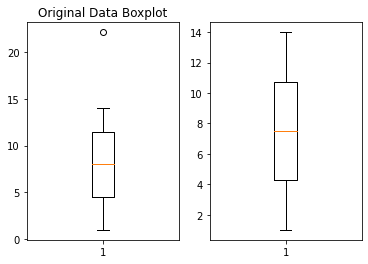

In [44]:
# 이상치 처리에 대해서 알아보자!
import numpy as np
import matplotlib.pyplot as plt

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

figure = plt.figure()

ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

ax1.set_title('Original Data Boxplot')
ax1.boxplot(data)

# numpy로 사분위 값을 구해서 Turkey Fence 방식으로 이상치를 판단해보자!
first = np.percentile(data, 25)   # 1사분위 값을 구한다
third = np.percentile(data, 75)   # 3사분위 값을 구한다
IQR_value = third - first

upper_fence = third + (IQR_value * 1.5)
lower_fence = first - (IQR_value * 1.5)

# boolean indexing을 이용해서 이상치를 추출해보자!
print(data[(data > upper_fence) | (data < lower_fence)])   # array([22.1])
# boolean indexing을 이용해서 이상치를 제거하고 나머지 데이터를 추출한다!
result = data[(data <= upper_fence) & (data >= lower_fence)]
ax2.boxplot(result)
plt.show()

In [45]:
import numpy as np
import matplotlib.pyplot as plt

data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

mean = data.mean()   # 8.473333333333333
std = data.std()     # 5.331974826980671

zscore_data = (data - mean) / std

print(zscore_data)

[-1.40160702 -1.21405925 -1.02651147 -0.8389637  -0.65141593 -0.46386816
 -0.27632038 -0.08877261  0.09877516  0.28632293  0.4738707   0.66141848
  0.84896625  1.03651402  2.55565098]


In [46]:
# scipy는 sklearn과 유사한 통계전용 모듈

from scipy import stats

data = np.array([-10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22.1])

zscore_threshold = 2.0   # 일반적인 기준.

# stats.zscore() => zscore 구하는 함수
# np.abs() => 절대값을 구하는 numpy 함수
outlier = data[(np.abs(stats.zscore(data)) > zscore_threshold)]
print(outlier)   # [-10.   22.1]

data[np.isin(data, outlier, invert=True)]
# invert=True : 해당 요소들만 제외한 나머지

[-10.   22.1]


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14.])

In [56]:
### 온도에 따른 오존량 예측 ==> Python 구현
### 결측치 처리와 이상치 처리도 같이 진행!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

################################################
# 다변수 함수에 대한 수치미분을 수행하는 함수
def numerical_derivative(f, x):   # x : ndarray [1.0  2.0]
                                  
    delta_x = 1e-4
    derivative_x = np.zeros_like(x)   # derivative_x : [0.0  0.0]
    
    # iterator를 이용해서 입력변수 x에 대한 편미분을 수행!
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished:
        
        idx = it.multi_index
        tmp = x[idx]             # tmp : 1.0
        
        x[idx] = tmp + delta_x   # x : ndarray [1.0001  2.0]
        fx_plus_delta = f(x)
        
        x[idx] = tmp - delta_x   # x : ndarray [0.9999  2.0]
        fx_minus_delta = f(x)
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = tmp             # x : ndarray [1.0  2.0]
        it.iternext()
        
    return derivative_x
################################################

# Raw Data Set Loading
df = pd.read_csv('../data/ozone.csv')
training_data = df[['Ozone', 'Temp']]

# 데이터에 결치값이 존재한다
# 여기서는 결치값을 삭제해서 진행해보자.
training_data.dropna(how='any',
                     inplace=True)   # how='any' : 결치가 존재하는 행을 삭제

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]


# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(1,1)
b = np.random.rand(1)

# loss function
def loss_func(input_data):
    W = input_data[0].reshape(1,1)
    b = input_data[1]
    
    y = np.dot(x_data,W) + b
    return np.mean(np.power(t_data-y, 2))

# predict
def predict(x):
    y = np.dot(x,W) + b
    return y

# learning_rate
learning_rate = 1e-4

# 반복 학습
for step in range(300000):
    
    # .ravel() => 1차원으로 만든다.
    # np.concatenate() => 서로 다른 값을 연결해서 하나의 ndarray로 만든다.
    #                     연결할 값들을 튜플로 작성한다.
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)  # [W b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[0].reshape(1,1)
    b = b - derivative_result[1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\976883435.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.dropna(how='any',


W : [[0.55330529]], b : [0.31113847], loss : 513.2446610176254
W : [[0.6307684]], b : [-10.29914305], loss : 455.47635041030514
W : [[0.75456479]], b : [-20.0168355], loss : 423.97321422390775
W : [[0.86795468]], b : [-28.91764443], loss : 397.54386634332366
W : [[0.97181284]], b : [-37.07023828], loss : 375.37113963059943
W : [[1.06694054]], b : [-44.53751311], loss : 356.76947710966243
W : [[1.15407166]], b : [-51.37707783], loss : 341.1637352886733
W : [[1.23387841]], b : [-57.64169869], loss : 328.07140133687
W : [[1.30697649]], b : [-63.3797063], loss : 317.0876743040999
W : [[1.37392984]], b : [-68.63536856], loss : 307.87294910884435


In [57]:
# 학습 종료 후 예측 (Temp : 62)
predict_data = predict(np.array([[62]]))
print('온도가 62일 때 오존량 : {}'.format(predict_data))  # [[16.90477881]]
                                                          # [[15.51698258]]

온도가 62일 때 오존량 : [[15.53660947]]


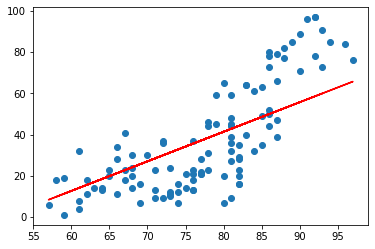

In [58]:
# 그래프로 표현해보자!
plt.scatter(x_data.ravel(), t_data.ravel())
plt.plot(x_data.ravel(), x_data.ravel()*W.ravel() + b, color='r')
plt.show()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\1272212093.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.dropna(how='any',


sklearn으로 구한 온도가 62도 일 때의 오존량 : [[4.51299041]]


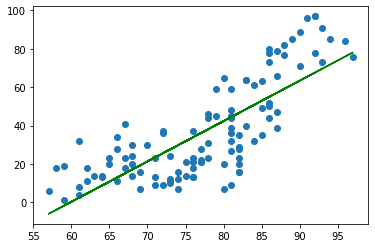

In [59]:
# 같은 데이터로 sklearn을 이용해서 구현해보자!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

df = pd.read_csv('../data/ozone.csv')
training_data = df[['Ozone', 'Temp']]
training_data.dropna(how='any',
                     inplace=True)   # how='any' : 결치가 존재하는 행을 삭제

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]


# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# model 생성
model = linear_model.LinearRegression()

# model 학습
model.fit(x_data, t_data)

# 예측
result = model.predict(np.array([[62]]))
print('sklearn으로 구한 온도가 62도 일 때의 오존량 : {}'.format(result))
# [[3.58411393]]   =>  [[4.51299041]]

# 그래프 표현
plt.scatter(x_data.ravel(), t_data.ravel())
plt.plot(x_data.ravel(),
         x_data.ravel()*model.coef_.ravel() + model.intercept_, color='g')
plt.show()

In [60]:
### 일단 Min-Max Scaling 작업을 어떻게 하면 되는지 알아보자!
import pandas as pd
import seaborn as sns

titanic = sns.load_dataset('titanic')
df = titanic[['age', 'fare']]

display(df.head())

def min_max(s):
    return (s - s.min()) / (s.max() - s.min())

result = df.apply(min_max, axis=0)

display(result.head())

,age,fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


,age,fare
0,0.271174,0.014151
1,0.472229,0.139136
2,0.321438,0.015469
3,0.434531,0.103644
4,0.434531,0.015713


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\3253340750.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.dropna(how='any',
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\3253340750.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data['Temp'] = scaled_Temp
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\3253340750.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

W : [[0.23092491]], b : [0.11860381], loss : 0.07006177982394401
W : [[0.42824825]], b : [0.16538924], loss : 0.03946249768551675
W : [[0.53167256]], b : [0.11044472], loss : 0.034864506222902686
W : [[0.61121263]], b : [0.06813184], loss : 0.03214335749591117
W : [[0.67240231]], b : [0.03558077], loss : 0.030532945815322465
W : [[0.71947516]], b : [0.01053943], loss : 0.029579882957988083
W : [[0.75568803]], b : [-0.00872472], loss : 0.029015847797923617
W : [[0.78354636]], b : [-0.02354451], loss : 0.028682044356376578
W : [[0.80497761]], b : [-0.03494529], loss : 0.028484495080235844
W : [[0.82146454]], b : [-0.04371584], loss : 0.02836758281497318
[[51.66668005]]


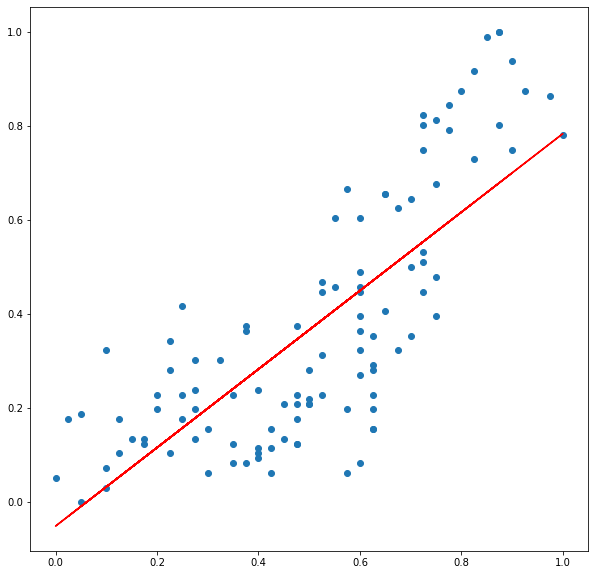

In [82]:
### 정규화 작업을 포함해서 모델 학습을 진행해보자!
### 그런데 이번에는 이 정규화 작업을 Min-Max Scaling으로 진행할 것이다.
### sklearn의 기능을 이용해서 정규화를 진행해보자!
# 같은 데이터로 sklearn을 이용해서 구현해보자!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model   # LinearRegression 모델
from scipy import stats   # 이상치 처리
from sklearn.preprocessing import MinMaxScaler   # 정규화 처리


####### 그래프
# figure = plt.figure()

# python_ax = figure.add_subplot(1,2,1)
# sklearn_ax = figure.add_subplot(1,2,2)
#######

df = pd.read_csv('../data/ozone.csv')
training_data = df[['Ozone', 'Temp']]
training_data.dropna(how='any',
                     inplace=True)   # how='any' : 결치가 존재하는 행을 삭제

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# 정규화 처리를 해야 한다!
# display(training_data.head())
# 일단 scaler를 만들어보자
scaler_x = MinMaxScaler()   # 온도 처리를 위한 scaler(독립변수들을 위한 scaler)
scaler_t = MinMaxScaler()   # 오존량 처리를 위한 scaler(종속변수를 위한 scaler)

# fit 함수를 통해 학습을 진행한다.
scaler_x.fit(training_data['Temp'].values.reshape(-1,1))
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

scaled_Temp = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
scaled_Ozone = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

training_data['Temp'] = scaled_Temp
training_data['Ozone'] = scaled_Ozone

# display(training_data.head())

#################################
# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(1,1)
b = np.random.rand(1)

# loss function
def loss_func(input_data):
    W = input_data[0].reshape(1,1)
    b = input_data[1]
    
    y = np.dot(x_data,W) + b
    return np.mean(np.power(t_data-y, 2))

# predict
def predict(x):
    y = np.dot(x,W) + b
    return y

# learning_rate
learning_rate = 1e-4

# 반복 학습
for step in range(300000):
    
    # .ravel() => 1차원으로 만든다.
    # np.concatenate() => 서로 다른 값을 연결해서 하나의 ndarray로 만든다.
    #                     연결할 값들을 튜플로 작성한다.
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)  # [W b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[0].reshape(1,1)
    b = b - derivative_result[1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))
        
# predict
result = predict([[62]])   # [[16.90477881]]  # [[51.07915522]]
print(result)

figure = plt.figure(figsize=(10,10))


python_ax = figure.add_subplot(1,1,1)
python_ax.scatter(x_data.ravel(), t_data.ravel())
python_ax.plot(x_data.ravel(), x_data.ravel()*W.ravel() + b, color='r')

plt.show()

In [83]:
# predict
# 아래처럼 하면 안된다!
# result = predict([[62]])   # [[16.90477881]]  # [[51.07915522]]

predict_data = np.array([[62]])
scaled_predict_data = scaler_x.transform(predict_data)
python_result = predict(scaled_predict_data)

# 정규화된 오존량이 나온다. => 결과값에 대해 정규화를 풀어주는 작업!
python_result = scaler_t.inverse_transform(python_result)

print(python_result)    # [[5.52388822]]



[[6.16534296]]


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5952\1027377424.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.dropna(how='any',


sklearn으로 구한 온도가 62도 일 때의 오존량 : [[54.2663519]]


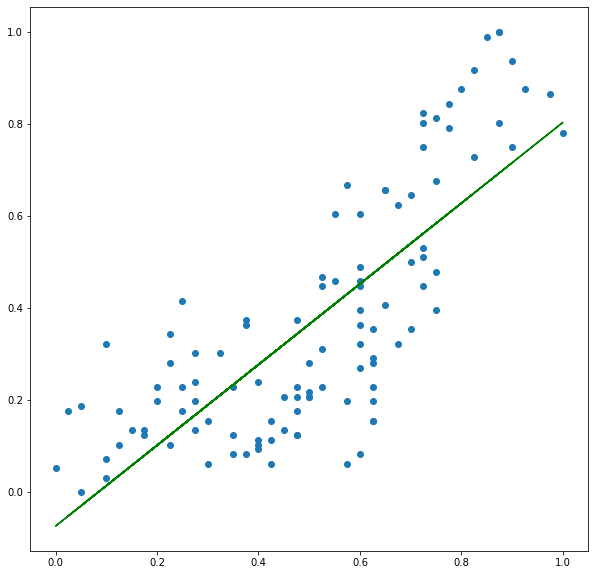

In [84]:
# sklearn 구현

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

df = pd.read_csv('../data/ozone.csv')
training_data = df[['Ozone', 'Temp']]
training_data.dropna(how='any',
                     inplace=True)   # how='any' : 결치가 존재하는 행을 삭제

# 데이터에 이상치가 있는지 확인하고 제거
zscore_threshold = 2.0
outlier = training_data['Ozone'][(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)]
training_data = training_data.loc[np.isin(training_data['Ozone'], outlier, invert=True)]

# 정규화는 안해도 된다! sklearn이 알아서 해준다!
# Training Data Set
# x_data = training_data['Temp'].values.reshape(-1,1)
# t_data = training_data['Ozone'].values.reshape(-1,1)

# model 생성
model = linear_model.LinearRegression()

# model 학습
model.fit(x_data, t_data)

# 예측
result = model.predict(np.array([[62]]))
print('sklearn으로 구한 온도가 62도 일 때의 오존량 : {}'.format(result))
# [[3.58411393]]   =>  [[4.51299041]]

figure = plt.figure(figsize=(10,10))

sklearn_ax = figure.add_subplot(1,1,1)
sklearn_ax.scatter(x_data.ravel(), t_data.ravel())
sklearn_ax.plot(x_data.ravel(), 
                x_data.ravel()*model.coef_.ravel() + model.intercept_, color='g')
plt.show()

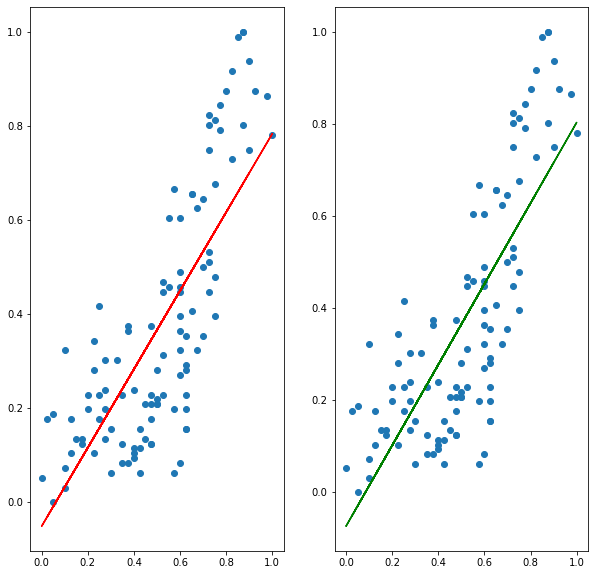

In [85]:
figure = plt.figure(figsize=(10,10))


python_ax = figure.add_subplot(1,2,1)
python_ax.scatter(x_data.ravel(), t_data.ravel())
python_ax.plot(x_data.ravel(), x_data.ravel()*W.ravel() + b, color='r')

sklearn_ax = figure.add_subplot(1,2,2)
sklearn_ax.scatter(x_data.ravel(), t_data.ravel())
sklearn_ax.plot(x_data.ravel(), 
                x_data.ravel()*model.coef_.ravel() + model.intercept_, color='g')

plt.show()

In [38]:
%reset
# 위의 셀들을 실행하면 함수나 변수 같은 것들이 메모리에 남아있다
# 그것들을 다 메모리에서 제거

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [41]:
# 새마음 새뜻으로 다시 해보자!
import numpy as np
import pandas as pd


################################################
# 다변수 함수에 대한 수치미분을 수행하는 함수
def numerical_derivative(f, x):   # x : ndarray [1.0  2.0]
                                  
    delta_x = 1e-4
    derivative_x = np.zeros_like(x)   # derivative_x : [0.0  0.0]
    
    # iterator를 이용해서 입력변수 x에 대한 편미분을 수행!
    it = np.nditer(x, flags=['multi_index'])
    
    while not it.finished:
        
        idx = it.multi_index
        tmp = x[idx]             # tmp : 1.0
        
        x[idx] = tmp + delta_x   # x : ndarray [1.0001  2.0]
        fx_plus_delta = f(x)
        
        x[idx] = tmp - delta_x   # x : ndarray [0.9999  2.0]
        fx_minus_delta = f(x)
        
        derivative_x[idx] = (fx_plus_delta - fx_minus_delta) / (2 * delta_x)
        
        x[idx] = tmp             # x : ndarray [1.0  2.0]
        it.iternext()
        
    return derivative_x
################################################

# Raw Data Loading
df = pd.read_csv('../data/student_exam_score.csv')
display(df)

# 결측치, 이상치가 존재하지 않는다.
# 각 변수의 scale이 비슷하기 때문에 정규화도 굳이 필요하지 않다.

# Training Data Set
x_data = df.drop('exam', axis=1, inplace=False)
t_data = df.iloc[:,-1].values.reshape(-1,1)

# Weight, bias
W = np.random.rand(3,1)
b = np.random.rand(1)

# loss function
def loss_func(input_data):   # [w1  w2  w3  b]
    
    input_w = input_data[:-1].reshape(-1,1)
    input_b = input_data[-1:]
    
    y = np.dot(x_data,input_w) + input_b
    
    return np.mean(np.power(t_data-y,2))   # MSE(평균제곱오차)

# predict
def predict(x):
    y = np.dot(x,W) + b
    return y

# learning_rate
learning_rate = 1e-5

# 반복 학습
for step in range(300000):
    
    # .ravel() => 1차원으로 만든다.
    # np.concatenate() => 서로 다른 값을 연결해서 하나의 ndarray로 만든다.
    #                     연결할 값들을 튜플로 작성한다.
    input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)  # [w1 w2 w3 b]
    derivative_result = learning_rate * numerical_derivative(loss_func, input_param)
    
    W = W - derivative_result[:-1].reshape(-1,1)
    b = b - derivative_result[-1]
    
    if step % 30000 == 0:
        input_param = np.concatenate((W.ravel(), b.ravel()), axis=0)
        print('W : {}, b : {}, loss : {}'.format(W, b, loss_func(input_param)))

,quiz1,quiz2,quiz3,exam
0,73,80,75,152
1,93,88,93,185
2,89,91,90,180
3,96,98,100,196
4,73,66,70,142
5,53,46,55,101
6,69,74,77,149
7,47,56,60,115
8,87,79,90,175
9,79,70,88,164


W : [[0.35252792]
 [0.19467958]
 [0.8468996 ]], b : [0.97967002], loss : 2438.2385080175595
W : [[0.35610486]
 [0.52770209]
 [1.11844794]], b : [0.92194457], loss : 6.270926550830655
W : [[0.35599377]
 [0.52793043]
 [1.11906101]], b : [0.86146679], loss : 6.258732910032729
W : [[0.35599307]
 [0.52809825]
 [1.11961755]], b : [0.80168401], loss : 6.246818381857972
W : [[0.35599243]
 [0.52826412]
 [1.12016765]], b : [0.74258885], loss : 6.235176360806019
W : [[0.35599181]
 [0.52842808]
 [1.12071143]], b : [0.6841734], loss : 6.2238006141388755
W : [[0.35599119]
 [0.52859015]
 [1.12124895]], b : [0.62642986], loss : 6.212685051672711
W : [[0.35599059]
 [0.52875036]
 [1.12178029]], b : [0.56935048], loss : 6.201823722517443
W : [[0.35598998]
 [0.52890872]
 [1.12230552]], b : [0.51292764], loss : 6.191210811890657
W : [[0.35598939]
 [0.52906527]
 [1.12282471]], b : [0.45715378], loss : 6.180840638004841


In [42]:
# predict
result = predict(np.array([[89, 100, 95]]))
print(result)   # [[191.72412825]]

[[191.72412825]]


In [43]:
# sklearn 구현
from sklearn import linear_model

model = linear_model.LinearRegression()

model.fit(x_data, t_data)

result_sklearn = model.predict(np.array([[89, 100, 95]]))
print(result_sklearn)   # [[192.50147537]]

[[192.50147537]]


C:\Users\shcho\anaconda3\envs\machine\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
